In [ ]:
#Import Statements
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

## Task 1: Exploratory data analysis

### (a)

In [ ]:
### Importing Train Data
train_filepath = '/Users/liamfitzsimons/Desktop/361 - A3/train.csv'#change to your filepath
train_data = pd.read_csv(train_filepath).drop(['ArticleId'], axis=1)
train_vectorizer = CountVectorizer()
X = train_vectorizer.fit_transform(train_data.iloc[:,0]).toarray()
y = train_data.iloc[:,1]

column_names = train_vectorizer.get_feature_names_out()

### Importing Test Data
test_filepath = '/Users/liamfitzsimons/Desktop/361 - A3/test.csv'#change to your filepath
test_data = pd.read_csv(test_filepath).drop('ArticleId', axis=1)
test_vectorizer = CountVectorizer(vocabulary = column_names)
test_X = test_vectorizer.fit_transform(test_data.iloc[:,0]).toarray()
test_y = test_data.iloc[:,1]

In [ ]:
print(f'The number of Articles in this Dataset is: {X.shape[0]}\n')# number of articles
print(f'The number of Extracted Features is: {X.shape[1]}\n')# number of extracted features

# re-import training data without dropping article ID to use for Task 1 Exploratory Analysis
train_data_2 = pd.read_csv(train_filepath)
train_X_df = pd.DataFrame(X)
train_X_df.columns = column_names
train_X_df.insert(0, 'ArticleId', train_data_2['ArticleId'])
train_X_df['Category'] = train_data_2['Category']
print("See below for first 5 rows of the training dataframe")
train_X_df.head(5)

The number of Articles in this Dataset is: 428

The number of Extracted Features is: 13518

See below for first 5 rows of the training dataframe


,ArticleId,00,000,000th,001st,0051,007,0100,0130,028,...,zombie,zombies,zone,zonealarm,zones,zoom,zooms,zooropa,zorro,Category
0,1976,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,tech
1,1797,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,entertainment
2,1866,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,entertainment
3,1153,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,entertainment
4,342,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,entertainment


### (b)

In [ ]:
####Frequency Plot Functions

def frequency_plot(title, df):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df['Text'])
    total_term_frequency = X.sum(axis=0)
    total_term_frequency = total_term_frequency.A1
    terms = vectorizer.get_feature_names_out()
    term_frequency_df = pd.DataFrame({"Term": terms, "Frequency": total_term_frequency})
    term_frequency_df = term_frequency_df.sort_values(by="Frequency", ascending=False).head(50)
    plt.figure(figsize=(18, 8))
    plt.bar(term_frequency_df["Term"], term_frequency_df["Frequency"])
    plt.title(f"Top-50 Term Frequency Distribution ({title})")
    plt.xlabel("Term")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def class_distribution_plot(title, df):
    class_distribution = df["Category"].value_counts()
    plt.figure(figsize=(8, 6))
    plt.bar(class_distribution.index, class_distribution.values)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

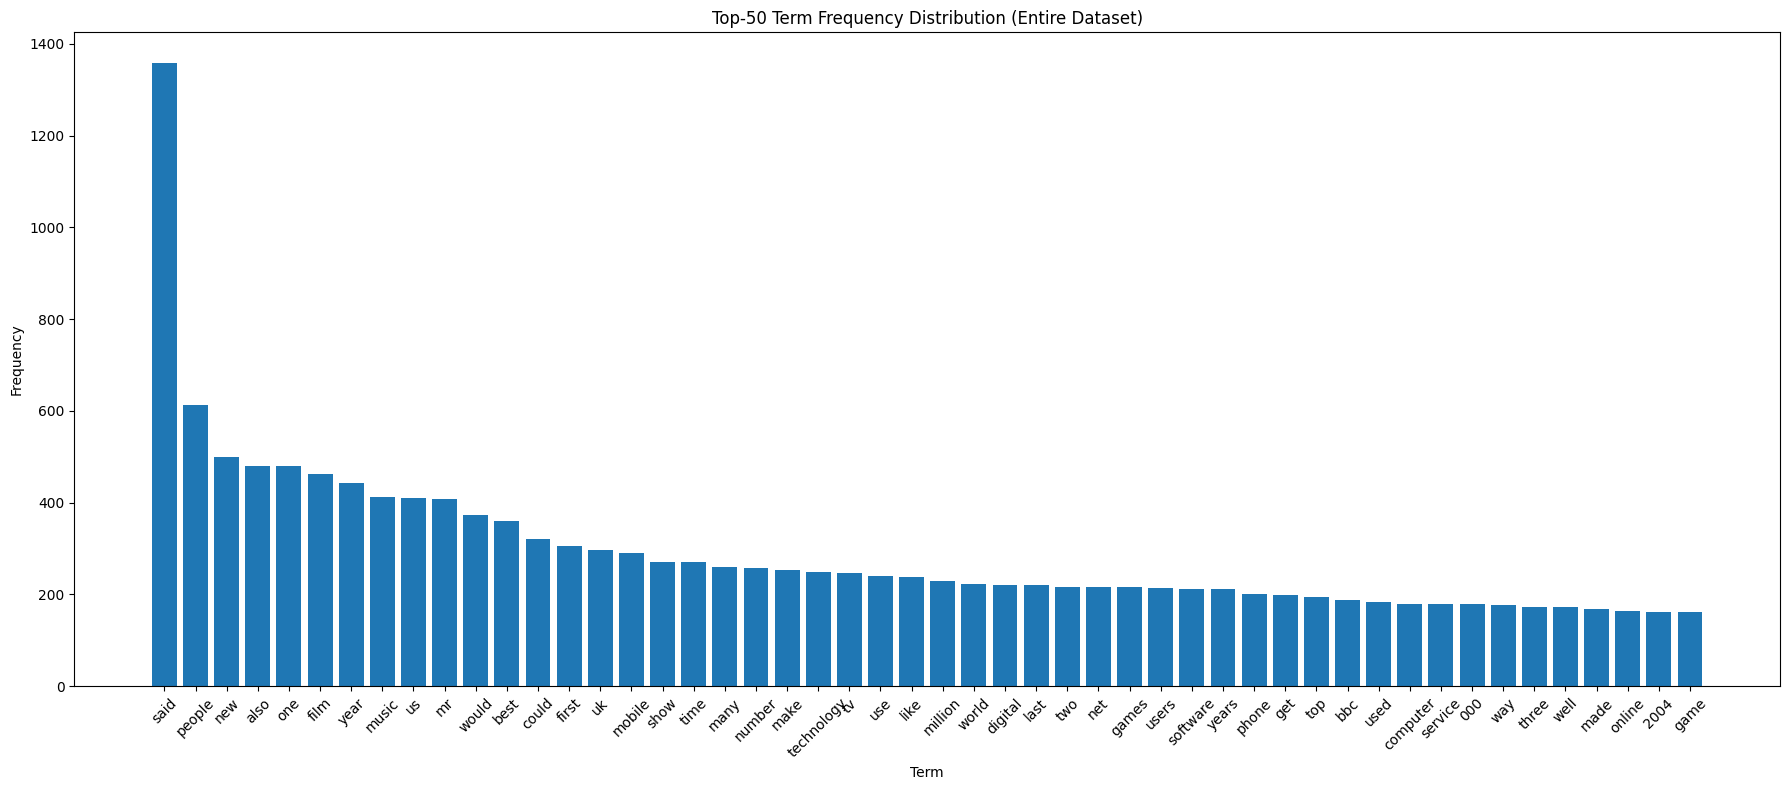

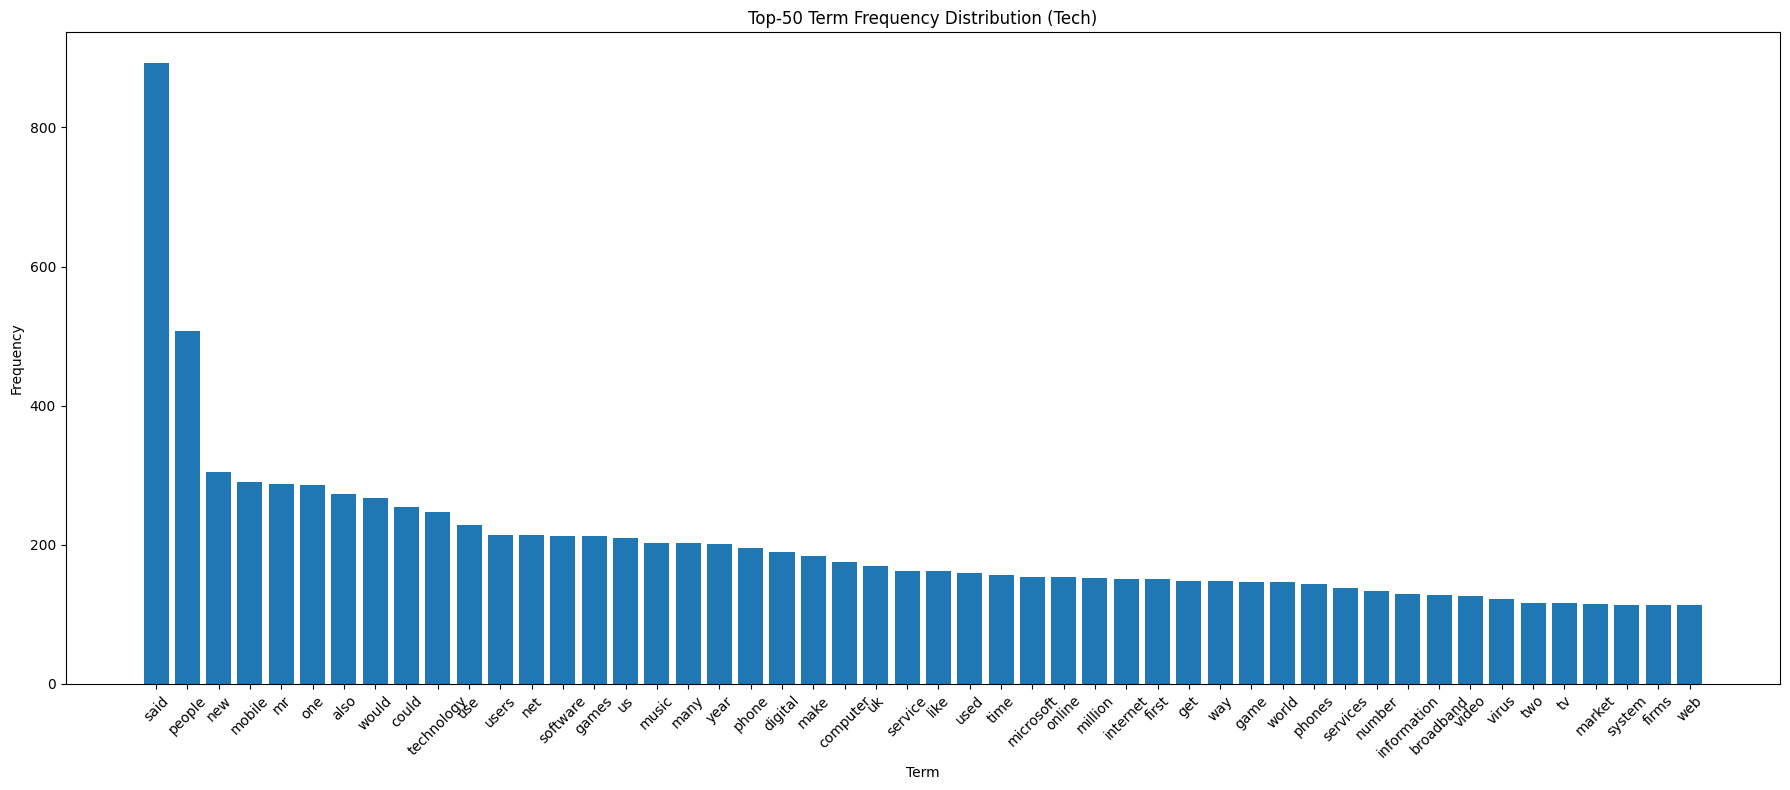

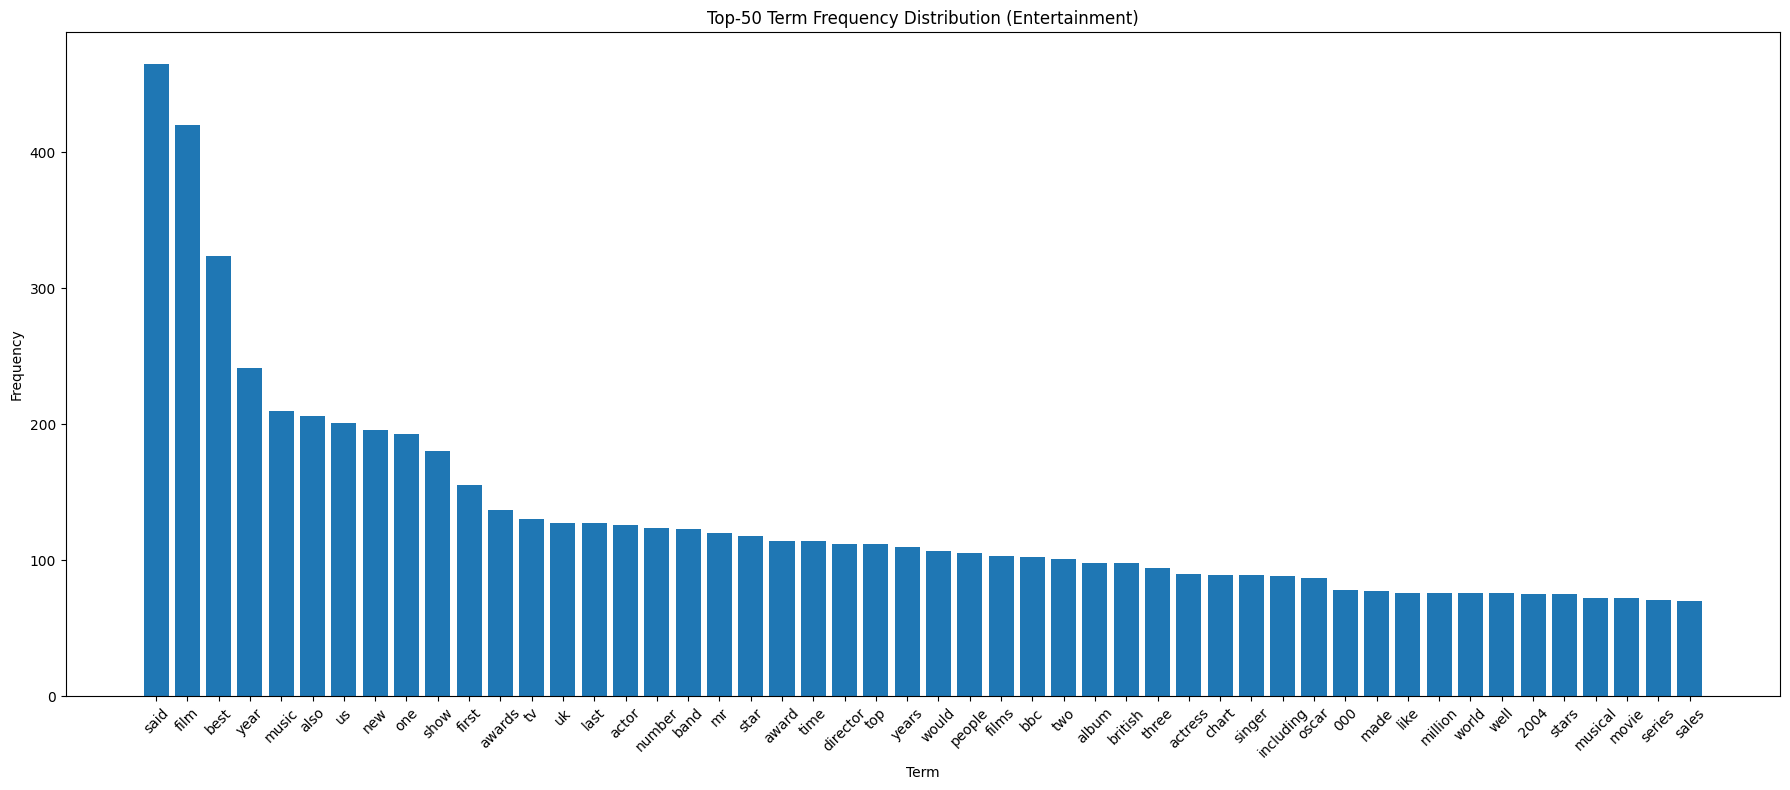

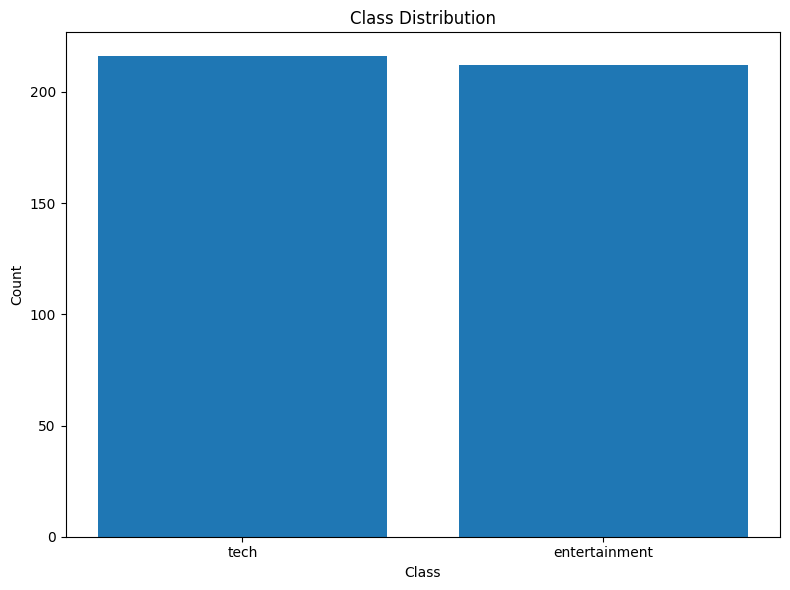

In [ ]:
####Frequency Plots

#i Entire Dataset
frequency_plot("Entire Dataset", train_data)

#ii(a) Tech
tech_df = train_data[train_data['Category'] == 'tech']
frequency_plot("Tech", tech_df)

#ii(b) Entertainment
entertainment_df = train_data[train_data['Category'] == 'entertainment']
frequency_plot("Entertainment", entertainment_df)

#iii Class Distribution
class_distribution_plot("Class Distribution", train_data)

## Task 2: Classification Models Learning

### (a) Naive Bayes

In [ ]:
# Naive Bayes Classifier
clf = BernoulliNB(force_alpha=True)
clf.fit(X, y)

BernoulliNB(force_alpha=True)

In [ ]:
#Gets Top 20 "Naive Bayes" most identifiable words
entertain_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()[::-1]
tech_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()[::-1]
print(f"Tech: Top 20 identifiable words {np.take(column_names, tech_class_prob_sorted[:20])}\n")
print(f"Entertainment: Top 20 identifiable words {np.take(column_names, entertain_class_prob_sorted[:20])}")


Tech: Top 20 identifiable words ['said' 'people' 'also' 'new' 'one' 'would' 'could' 'year' 'use' 'many'
 'technology' 'make' 'way' 'mr' 'us' 'users' 'time' 'like' 'get' 'used']

Entertainment: Top 20 identifiable words ['said' 'year' 'also' 'one' 'film' 'us' 'new' 'first' 'last' 'best' 'show'
 'two' 'time' 'star' 'tv' 'years' 'including' 'music' 'uk' 'would']


In [ ]:
#Gets Top 20 "Naive Bayes" most identifiable words after applying Conditional Probability Ratio Maximisers
X1 = pd.DataFrame(X, columns = column_names)
y1 = pd.DataFrame(y, columns = ["Category"])
dataset = pd.concat([X1, y1], axis = 1)
vals = dataset.groupby('Category').sum().sum(axis=1)

dataset = dataset.groupby('Category').sum().T
dataset['entertainment'] = (dataset['entertainment']+1)/(vals['entertainment']+len(column_names)) ###LAPLACE SMOOTHING
dataset['tech'] = (dataset['tech']+1)/(vals['tech']+len(column_names)) ###LAPLACE SMOOTHING
dataset['tech1'] = dataset['tech']
dataset['tech'] = dataset['tech']/dataset['entertainment']
dataset['entertainment'] = dataset['entertainment']/dataset['tech1']
dataset.drop(['tech1'], axis = 1)

print("Entertainment: Top 20 identifiable words after applying Conditional Probability Ratio Maximisers")
print(dataset['entertainment'].sort_values(ascending = False).head(20))
print()
print("Tech: Top 20 identifiable words after applying Conditional Probability Ratio Maximisers")
print(dataset['tech'].sort_values(ascending = False).head(20))

Entertainment: Top 20 identifiable words after applying Conditional Probability Ratio Maximisers
actress        124.349418
singer         122.982941
oscar          120.249986
stars          103.852261
aviator         86.088058
band            84.721581
nominated       75.156242
festival        72.423287
rock            72.423287
album           67.640617
nominations     65.590902
charles         64.224425
chart           61.491470
foxx            60.124993
oscars          58.758516
starring        57.392039
singles         51.926131
jamie           47.826699
swank           45.093745
comedy          44.410506
Name: entertainment, dtype: float64

Tech: Top 20 identifiable words after applying Conditional Probability Ratio Maximisers
users           157.338895
software        156.607086
microsoft       113.430366
mobile          106.478182
broadband        94.403337
virus            90.012484
firms            83.426205
pc               79.767161
spam             62.203749
phones         

### (b) kNN

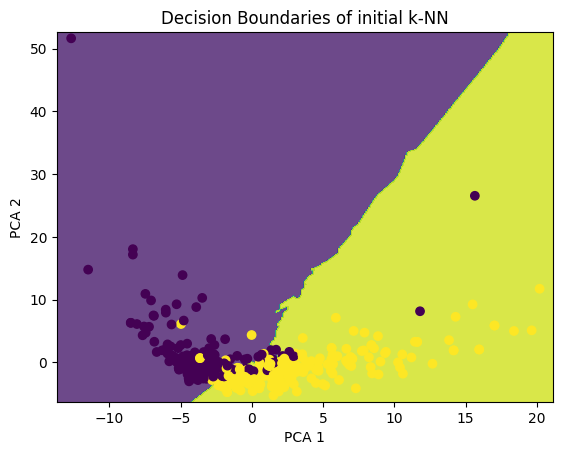

In [ ]:
# kNN Classifier

# Change String Class Labels to Integer Labels
label_encoder = LabelEncoder()
y_kNN = label_encoder.fit_transform(y)

# Apply PCA Dimension Reduction
pca = PCA(n_components=2)
X_kNN = pca.fit_transform(X)

# Choice of Hyper-parameter
root_n = round(math.sqrt(len(X)))

# Training kNN classifier With Default Hyper-parameters on Training Dataset
knn = KNeighborsClassifier(n_neighbors=root_n, metric = 'euclidean')
knn.fit(X_kNN, y_kNN)

# Define the Range of X and y values
x_min, x_max = X_kNN[:, 0].min() - 1, X_kNN[:, 0].max() + 1
y_min, y_max = X_kNN[:, 1].min() - 1, X_kNN[:, 1].max() + 1

# Generate a Grid of Points Within the Range
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predicting the Class Labels
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_kNN[:, 0], X_kNN[:, 1], c= y_kNN)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Decision Boundaries of initial k-NN')
plt.show()

### (c) SVM

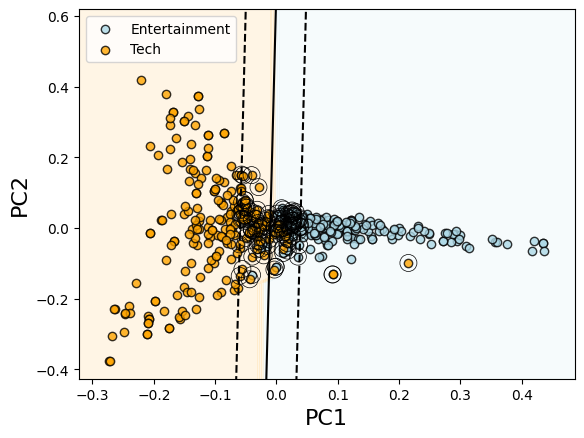

In [ ]:
def plot_decision_regions(X, y, ax, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('lightblue', 'orange', 'lightgreen', 'gray', 'cyan')
    background = ('lightcyan', 'papayawhip')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    category_names = ['Entertainment', 'Tech'] # Define category names here

    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    color=colors[idx],
                    marker='o', # Change marker to a filled one
                    label=category_names[cl], # Use category names as labels
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]


        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            ax.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100,
                        label='test set')
        else:
            ax.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100,
                        label='test set')
    ax.set_xlabel('PC1', size=16)
    ax.set_ylabel('PC2', size=16)
    ax.legend(loc='upper left')



data = pd.read_csv(train_filepath)
X2 = data['Text']
y2 = data['Category']

encoder = LabelEncoder()
y2 = encoder.fit_transform(y2)

vectorizer = TfidfVectorizer()
X2 = vectorizer.fit_transform(X2)

pca = PCA(n_components=2)
X2 = pca.fit_transform(X2.toarray())

C = 10 # Set the value of C here
model = SVC(kernel='linear', C=C)
model.fit(X2, y2)


fig, ax = plt.subplots()
plot_decision_regions(X2, y2, ax, classifier=model)

x_min, x_max = X2[:, 0].min() -0.05, X2[:, 0].max() + 0.05
y_min, y_max = X2[:, 1].min() -0.05, X2[:, 1].max() + 0.20
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.scatter(model.support_vectors_[:, 0],
           model.support_vectors_[:, 1],
           s=150, linewidth=0.5, edgecolor='black', facecolors='none')

w = model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1)
yy = a * xx - (model.intercept_[0]) / w[1]

margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

ax.plot(xx, yy, 'k-')
ax.plot(xx, yy_down, 'k--')
ax.plot(xx, yy_up, 'k--')

plt.show()

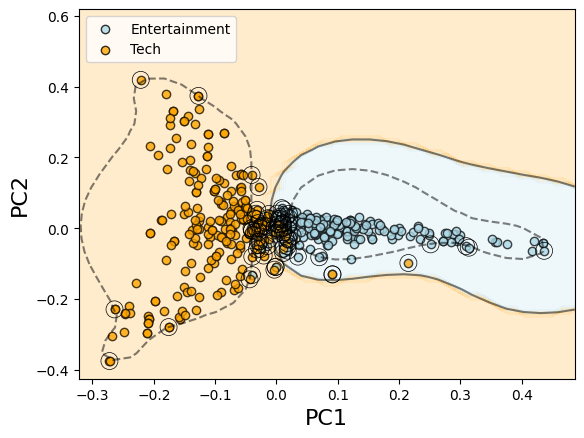

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # plot the decision surface
    colors = ('lightblue', 'orange', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:2])
    x1_min, x1_max = xlim[0] - 1, xlim[1] + 1
    x2_min, x2_max = ylim[0] - 1, ylim[1] + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=150, linewidth=0.5, edgecolor='black', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

data = pd.read_csv(train_filepath)
X3 = data['Text']
y3 = data['Category']

encoder = LabelEncoder()
y3 = encoder.fit_transform(y3)

vectorizer = TfidfVectorizer()
X3 = vectorizer.fit_transform(X3)

pca = PCA(n_components=2)
X3 = pca.fit_transform(X3.toarray())

C = 1.0

model = SVC(kernel='rbf', gamma='scale', C=C).fit(X3, y3)

fig, ax = plt.subplots()
plot_decision_regions(X3, y3, ax, classifier=model)

x_min, x_max = X3[:, 0].min() -0.05, X3[:, 0].max() + 0.05
y_min, y_max = X3[:, 1].min() -0.05, X3[:, 1].max() + 0.20
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plot_svc_decision_function(model, ax=ax)

plt.show()

### (d) Neural Network (NN)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


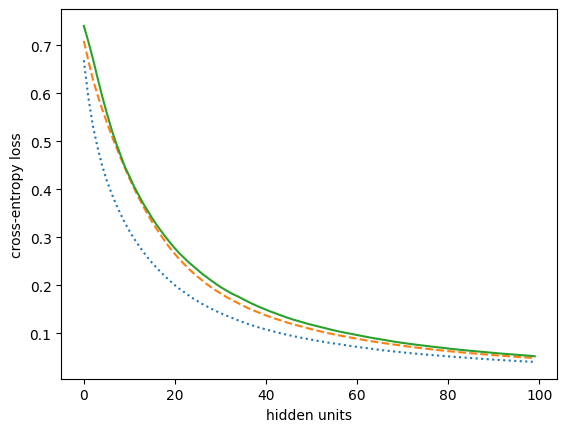

In [ ]:
vectorizer = CountVectorizer()
X1 = vectorizer.fit_transform(train_data.iloc[:,0]).toarray()
colnames = vectorizer.get_feature_names_out()
y1 = train_data.iloc[:,1]
NN = MLPClassifier(hidden_layer_sizes=(40),max_iter  = 100, learning_rate  = 'constant',learning_rate_init = 0.01, solver = 'sgd', momentum=0, random_state = 0)
NN1 = MLPClassifier(hidden_layer_sizes=(20),max_iter  = 100, learning_rate  = 'constant',learning_rate_init = 0.01, solver = 'sgd', momentum=0, random_state = 0)
NN2 = MLPClassifier(hidden_layer_sizes=(5),max_iter  = 100, learning_rate  = 'constant',learning_rate_init = 0.01, solver = 'sgd', momentum=0,random_state = 0)
NN.fit(X1, y1)
NN1.fit(X1, y1)
NN2.fit(X1, y1)
plt.plot(NN.loss_curve_,  linestyle = 'dotted')
plt.plot(NN1.loss_curve_,  linestyle = '--')
plt.plot(NN2.loss_curve_)
plt.xlabel('hidden units')
plt.ylabel('cross-entropy loss')
plt.show()

## Task 3: Classification Quality Evaluation

### 3 (a) Size of Traing Data on Training & Test Accuracy

### Naive Bayes

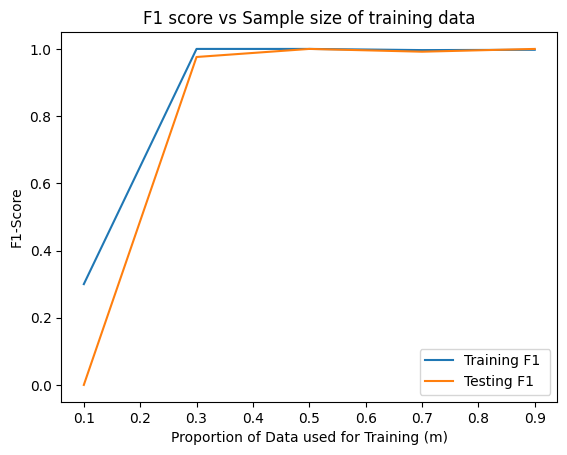

In [ ]:
### Naive Bayes
#PUTS F1 SCORE VS TRAINING SIZE INTO DICTIONARIES
proportions = [0.1, 0.3, 0.5, 0.7, 0.9]
training_f1 = {}
testing_f1 ={}
for proportion in proportions:
  numRows = int(len(X)*proportion)
  train_X = X[:numRows]
  train_y = y[:numRows]

  clf = BernoulliNB(force_alpha=True)
  clf.fit(train_X, train_y)

  predict_train = clf.predict(train_X)
  predict_test = clf.predict(test_X)

  train_f1_score = f1_score(train_y, predict_train, pos_label = 'entertainment')
  test_f1_score = f1_score(test_y, predict_test, pos_label = 'entertainment')

  training_f1[proportion] = train_f1_score
  testing_f1[proportion] = test_f1_score
def draw_line_graph(dict1, dict2):
    # Extract x and y values from the dictionaries
    x1 = list(dict1.keys())
    y1 = list(dict1.values())

    x2 = list(dict2.keys())
    y2 = list(dict2.values())

    # Create the line graph
    plt.plot(x1, y1, label= 'Training F1 ')
    plt.plot(x2, y2, label='Testing F1')

    # Add labels and title
    plt.xlabel('Proportion of Data used for Training (m)')
    plt.ylabel('F1-Score')
    plt.title('F1 score vs Sample size of training data')

    # Add legend
    plt.legend()

    # Display the graph
    plt.show()

# Example dictionaries

# Draw the line graph
draw_line_graph(training_f1, testing_f1)

### kNN

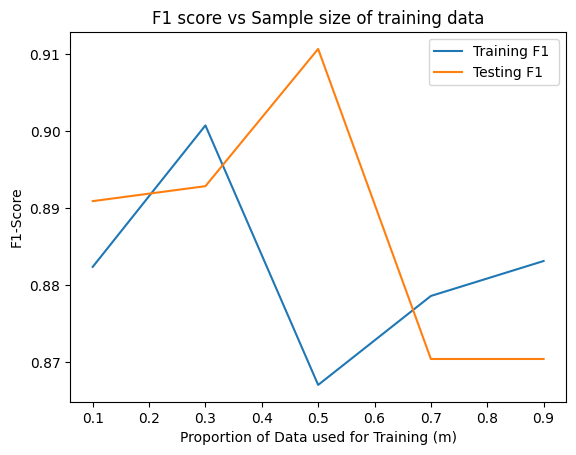

In [ ]:
### kNN
proportions = [0.1, 0.3, 0.5, 0.7, 0.9]
training_f1 = {}
testing_f1 ={}
for proportion in proportions:
    numRows = int(len(X)*proportion)
    train_X_kNN = X_kNN[:numRows]
    train_y_kNN = y_kNN[:numRows]
    #change string class labels into integer labels
    label_encoder = LabelEncoder()
    test_y_kNN = label_encoder.fit_transform(test_y)
    #Apply pca dimension reduction
    pca = PCA(n_components=2)
    test_X_kNN = pca.fit_transform(test_X)
    #fit kNN model on training set
    knn = KNeighborsClassifier(n_neighbors=root_n, metric = 'euclidean')
    knn.fit(train_X_kNN, train_y_kNN)
    #predict for both test and train dataset
    predict_train = knn.predict(train_X_kNN)
    predict_test = knn.predict(test_X_kNN)
    #calculate f1 score of the model for test and train
    train_f1_score = f1_score(train_y_kNN, predict_train, pos_label = 0)
    test_f1_score = f1_score(test_y_kNN, predict_test, pos_label = 0)
    training_f1[proportion] = train_f1_score
    testing_f1[proportion] = test_f1_score
def draw_line_graph(dict1, dict2):
    # Extract x and y values from the dictionaries
    x1 = list(dict1.keys())
    y1 = list(dict1.values())

    x2 = list(dict2.keys())
    y2 = list(dict2.values())

    # Create the line graph
    plt.plot(x1, y1, label= 'Training F1 ')
    plt.plot(x2, y2, label='Testing F1')

    # Add labels and title
    plt.xlabel('Proportion of Data used for Training (m)')
    plt.ylabel('F1-Score')
    plt.title('F1 score vs Sample size of training data')

    # Add legend
    plt.legend()

    # Display the graph
    plt.show()

# Example dictionaries

# Draw the line graph
draw_line_graph(training_f1, testing_f1)

### SVM

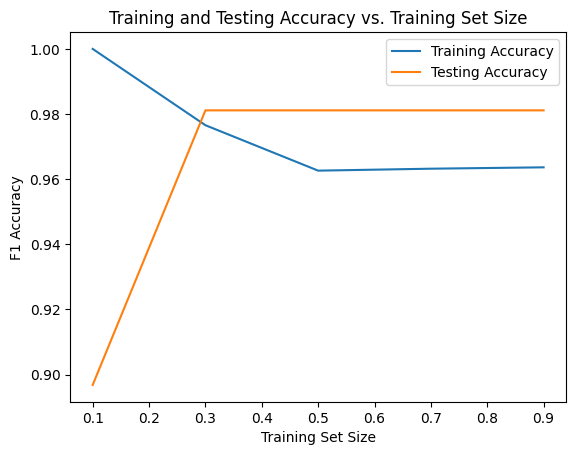

In [ ]:
data4 = pd.read_csv(train_filepath)
X4 = data4['Text']
y4 = data4['Category']

encoder = LabelEncoder()
y4 = encoder.fit_transform(y4)

vectorizer = TfidfVectorizer()
X4 = vectorizer.fit_transform(X4)

pca = PCA(n_components=2)
X4 = pca.fit_transform(X4.toarray())

C = 10

test_data4 = pd.read_csv(test_filepath)
X4_test = test_data4['Text']
y4_test = test_data4['Category']
y4_test = encoder.transform(y4_test)
X4_test = vectorizer.transform(X4_test)
X4_test = pca.transform(X4_test.toarray())

train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]
train_accs = []
test_accs = []

for m in train_sizes:
    X_train_subset = X4[:int(m * len(X4))]
    y_train_subset = y4[:int(m * len(y4))]
    model = SVC(kernel='rbf', gamma='scale', C=C)
    model.fit(X_train_subset, y_train_subset)
    y_train_pred = model.predict(X_train_subset)
    y_test_pred = model.predict(X4_test)
    train_f1 = f1_score(y_train_subset, y_train_pred, average='weighted')
    test_f1 = f1_score(y4_test, y_test_pred, average='weighted')
    train_accs.append(train_f1)
    test_accs.append(test_f1)

plt.plot(train_sizes, train_accs, label='Training Accuracy')
plt.plot(train_sizes, test_accs, label='Testing Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Accuracy')
plt.title('Training and Testing Accuracy vs. Training Set Size')
plt.legend()
plt.show()

### NN

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) 

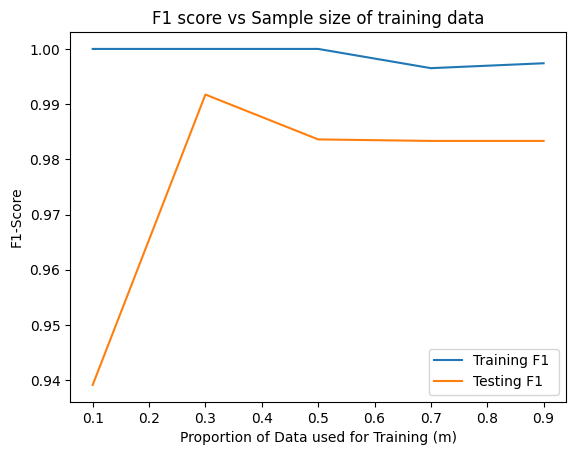

In [ ]:
proportions = [0.1, 0.3, 0.5, 0.7, 0.9]
training_f1 = {}
testing_f1 ={}
for proportion in proportions:
    numRows = int(len(X)*proportion)
    train_X = X[:numRows]
    train_y = y[:numRows]
    clf = MLPClassifier(hidden_layer_sizes=(40),max_iter  = 100, learning_rate  = 'constant',learning_rate_init = 0.01, solver = 'sgd', momentum=0,random_state=0)
    clf.fit(train_X, train_y)
    predict_train = clf.predict(train_X)
    predict_test = clf.predict(test_X)
    train_f1_score = f1_score(train_y, predict_train, pos_label = 'tech')
    test_f1_score = f1_score(test_y, predict_test, pos_label = 'tech')
    training_f1[proportion] = train_f1_score
    testing_f1[proportion] = test_f1_score
proportions = [0.1, 0.3, 0.5, 0.7, 0.9]
training_f1 = {}
testing_f1 ={}
for proportion in proportions:
  numRows = int(len(X)*proportion)
  train_X = X[:numRows]
  train_y = y[:numRows]
  clf = MLPClassifier(hidden_layer_sizes=(40),max_iter  = 100, learning_rate  = 'constant',learning_rate_init = 0.01, solver = 'sgd', momentum=0,random_state=0)
  clf.fit(train_X, train_y)
  predict_train = clf.predict(train_X)
  predict_test = clf.predict(test_X)
  train_f1_score = f1_score(train_y, predict_train, pos_label = 'entertainment')
  test_f1_score = f1_score(test_y, predict_test, pos_label = 'entertainment')
  training_f1[proportion] = train_f1_score
  testing_f1[proportion] = test_f1_score
def draw_line_graph(dict1, dict2):
    # Extract x and y values from the dictionaries
    x1 = list(dict1.keys())
    y1 = list(dict1.values())

    x2 = list(dict2.keys())
    y2 = list(dict2.values())

    # Create the line graph
    plt.plot(x1, y1, label= 'Training F1 ')
    plt.plot(x2, y2, label='Testing F1')

    # Add labels and title
    plt.xlabel('Proportion of Data used for Training (m)')
    plt.ylabel('F1-Score')
    plt.title('F1 score vs Sample size of training data')

    # Add legend
    plt.legend()

    # Display the graph
    plt.show()

# Draw the line graph
draw_line_graph(training_f1, testing_f1)

## 3 (b) Five-fold Cross-validation

### NB

In [ ]:
### Naive Bayes
def FiveFoldCrossValidation(X, y, model):
  kf = KFold(n_splits=5)
  accuracies = []
  for train_index, test_index in kf.split(X):
    # Get the training and testing data for this fold
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # Train a model on the training data
    model.fit(X_train, y_train)
    # Evaluate the model on the testing data
    score = model.score(X_test, y_test)
    accuracies.append(score)
  return sum(accuracies)/len(accuracies)
for k in range(0, 5):
  print(FiveFoldCrossValidation(X, y, BernoulliNB(force_alpha=True, alpha = k)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/naive_bayes.py:1216: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/naive_bayes.py:1216: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/naive_bayes.py:1216: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Library/F

0.4954035567715458
0.9579753761969905
0.9556497948016416
0.9509986320109439
0.9440218878248974


### kNN

In [ ]:
def FiveFoldCrossValidation(X, y, model):
  kf = KFold(n_splits=5)
  accuracies = []
  for train_index, test_index in kf.split(X):
    # Get the training and testing data for this fold
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # Train a model (e.g., Linear Regression) on the training data
    model.fit(X_train, y_train)
    # Evaluate the model on the testing data
    score = model.score(X_test, y_test)
    accuracies.append(score)
  return sum(accuracies)/len(accuracies)
distance_metrics = ['euclidean', 'manhattan', 'cosine', 'minkowski']
best_parameter = [0, 0]
best_accuracy = 0
root_n = round(math.sqrt(len(X)))
for d_metric in distance_metrics:
    for k in range(1, root_n + 5):
        accuracy = FiveFoldCrossValidation(X_kNN, y_kNN, KNeighborsClassifier(n_neighbors=k, p=2, metric= d_metric))
        if accuracy > best_accuracy:
            best_parameter[0] = d_metric
            best_parameter[1] = k
            best_accuracy = accuracy

#accuracy of initial kNN settings
initial_model = KNeighborsClassifier(n_neighbors=root_n, metric = 'euclidean')
initial_accuracy = FiveFoldCrossValidation(X_kNN, y_kNN, initial_model)
print("The accuracy of kNN with intial parameters is {}".format(initial_accuracy))

# kNN with tuned hyperparameters
tuned_model = KNeighborsClassifier(n_neighbors=7, metric = 'cosine')
tuned_accuracy = FiveFoldCrossValidation(X_kNN, y_kNN, tuned_model)
print("The accuracy of kNN with tuned parameters is {}".format(tuned_accuracy))

The accuracy of kNN with intial parameters is 0.8926675786593709
The accuracy of kNN with tuned parameters is 0.9043228454172368


We can see that the best tuning for the best hyper-parameters for the kNN model revealed that the cosine distance metric and using k = 7 lead to the best accuracy of 0.9043228454172368. This is better when compared to out initial estimation of what would be the best hyperparameters in 2b, which gave an accuracy of 0.8926675786593709.

### SVM

In [ ]:
def FiveFoldCrossValidation(X, y, model):
    kf = KFold(n_splits=5)
    accuracies = []
    for train_index, test_index in kf.split(X):
        # Get the training and testing data for this fold
        X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

        # Train a model on the training data
        model.fit(X_train, y_train)
        # Evaluate the model on the testing data
        score = model.score(X_test, y_test)
        accuracies.append(score)
    return sum(accuracies)/len(accuracies)

data5 = pd.read_csv(test_filepath)
X5 = data5['Text']
y5 = data5['Category']

encoder = LabelEncoder()
y5 = encoder.fit_transform(y5)

vectorizer = TfidfVectorizer()
X5 = vectorizer.fit_transform(X5)

pca = PCA(n_components=2)
X5 = pca.fit_transform(X5.toarray())

C_range = [0.01, 0.1, 1.0, 10.0, 100.0]
gamma_range = [0.01, 0.1, 1.0, 10.0, 100.0]

for C in C_range:
    for gamma in gamma_range:
        svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=0)
        accuracy = FiveFoldCrossValidation(X5, y5, svm)
        print(f'C: {C}, gamma: {gamma}, Cross-validation accuracy: {accuracy}')

C: 0.01, gamma: 0.01, Cross-validation accuracy: 0.574025974025974
C: 0.01, gamma: 0.1, Cross-validation accuracy: 0.574025974025974
C: 0.01, gamma: 1.0, Cross-validation accuracy: 0.574025974025974
C: 0.01, gamma: 10.0, Cross-validation accuracy: 0.574025974025974
C: 0.01, gamma: 100.0, Cross-validation accuracy: 0.574025974025974
C: 0.1, gamma: 0.01, Cross-validation accuracy: 0.574025974025974
C: 0.1, gamma: 0.1, Cross-validation accuracy: 0.574025974025974
C: 0.1, gamma: 1.0, Cross-validation accuracy: 0.574025974025974
C: 0.1, gamma: 10.0, Cross-validation accuracy: 0.9428571428571428
C: 0.1, gamma: 100.0, Cross-validation accuracy: 0.9333333333333333
C: 1.0, gamma: 0.01, Cross-validation accuracy: 0.574025974025974
C: 1.0, gamma: 0.1, Cross-validation accuracy: 0.5926406926406926
C: 1.0, gamma: 1.0, Cross-validation accuracy: 0.9523809523809523
C: 1.0, gamma: 10.0, Cross-validation accuracy: 0.9523809523809523
C: 1.0, gamma: 100.0, Cross-validation accuracy: 0.9523809523809523
C:

### NN

In [ ]:
def FiveFoldCrossValidation(X, y, model):
  kf = KFold(n_splits=5)
  accuracies = []
  for train_index, test_index in kf.split(X):
    # Get the training and testing data for this fold
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # Train a model (e.g., Linear Regression) on the training data
    model.fit(X_train, y_train)
    # Evaluate the model on the testing data
    score = model.score(X_test, y_test)
    accuracies.append(score)
  return sum(accuracies)/len(accuracies)
#### HYPERPARAMETER TUNING:
print(FiveFoldCrossValidation(X1, y1, MLPClassifier(hidden_layer_sizes=(40),max_iter  = 100, learning_rate  = 'constant',learning_rate_init = 0.01, solver = 'sgd', momentum=0,random_state=0)))
print(FiveFoldCrossValidation(X1, y1, MLPClassifier(hidden_layer_sizes=(40),max_iter  = 100, learning_rate  = 'constant',learning_rate_init = 0.1, solver = 'sgd', momentum=0,random_state=0)))
print(FiveFoldCrossValidation(X1, y1, MLPClassifier(hidden_layer_sizes=(40),max_iter  = 100, learning_rate  = 'constant',learning_rate_init = 1.0, solver = 'sgd', momentum=0,random_state=0)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) 

0.9836662106703147
0.981313269493844
0.9812859097127223


After observing the hyperparameters, the one with the best accuracy is the one with the learning_rate_init of 0.01 which has an accuracy of 0.9836662106703147. The one with the learning_rate_init of 0.1 has an accuracy of 0.981313269493844 and The one with the learning_rate_init of 1.0 has an accuracy of 0.9812859097127223.

## 3 (c) Classifiers With Best Hyper-parameters and Their Associated F1 Scores As Measured on the Testing Dataset.

### Naive Bayes

In [ ]:
model = BernoulliNB()
model.fit(X, y)
pred = model.predict(test_X)
print("Model Accuracy -> F1 score = " + str(accuracy_score(pred, test_y)))

Model Accuracy -> F1 score = 1.0


### kNN

In [ ]:
tuned_kNN = KNeighborsClassifier(n_neighbors=7, metric = 'cosine')
tuned_kNN.fit(X_kNN, y_kNN)
predict_test = tuned_kNN.predict(test_X_kNN)
kNN_f1score = f1_score(test_y_kNN, predict_test, pos_label = 0)
print("The f1_score for the trained kNN model on the test data is: {}".format(kNN_f1score))

The f1_score for the trained kNN model on the test data is: 0.8411214953271028


### SVM

In [ ]:
data6 = pd.read_csv(train_filepath)
X_train6 = data6['Text']
y_train6 = data6['Category']

test_data6 = pd.read_csv(test_filepath)
X_test6 = test_data6['Text']
y_test6 = test_data6['Category']

encoder = LabelEncoder()
y_train6 = encoder.fit_transform(y_train6)

vectorizer = TfidfVectorizer()
X_train6 = vectorizer.fit_transform(X_train6)

pca = PCA(n_components=2)
X_train6 = pca.fit_transform(X_train6.toarray())

y_test6 = encoder.transform(y_test6)
X_test6 = vectorizer.transform(X_test6)
X_test6 = pca.transform(X_test6.toarray())

C = 10
model = SVC(kernel='rbf', gamma=100, C=C)
model.fit(X_train6, y_train6)

y_test_pred6 = model.predict(X_test6)
test_f1 = f1_score(y_test6, y_test_pred6, average='weighted')
print('The f1_score for the trained RBF SVM model on the test data is:', test_f1)


The f1_score for the trained RBF SVM model on the test data is: 0.9811320754716981


### NN

In [ ]:
### NN
tuned_NN = MLPClassifier(hidden_layer_sizes=(40),max_iter  = 100, learning_rate  = 'constant',learning_rate_init = 0.01, solver = 'sgd', momentum=0,random_state=0)
tuned_NN.fit(X, y)
predict_test = tuned_NN.predict(test_X)
NN_f1score = f1_score(test_y, predict_test, pos_label = 'tech')
print("The f1_score for the trained NN model on the test data is: {}".format(NN_f1score))

The f1_score for the trained NN model on the test data is: 0.989010989010989


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
